<center>

https://bit.ly/8723EnrichmentS2
</center>

### Libraries

In [ ]:
!pip install transformers datasets evaluate -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 54.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 109.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.3 MB/s eta 0:00:00


In [ ]:
!pip install accelerate -U -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 4.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
from datasets import Dataset, load_dataset

#FOR LSTM & CNN
import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM, Bidirectional, Conv1D, GlobalMaxPooling1D, Flatten, Input, concatenate, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam

#FOR BERT
import evaluate
import accelerate
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer, create_optimizer


In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

### Load Dataset

In [ ]:
data = load_dataset('rotten_tomatoes')

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Dataset rotten_tomatoes downloaded and prepared to /root/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

#### Data Exploration on Datasets

In [ ]:
pd.Series(data['train']['label']).value_counts()

1    4265
0    4265
dtype: int64

In [ ]:
data['validation']['text']

['compassionately explores the seemingly irreconcilable situation between conservative christian parents and their estranged gay and lesbian children .',
 'the soundtrack alone is worth the price of admission .',
 'rodriguez does a splendid job of racial profiling hollywood style--casting excellent latin actors of all ages--a trend long overdue .',
 "beneath the film's obvious determination to shock at any cost lies considerable skill and determination , backed by sheer nerve .",
 'bielinsky is a filmmaker of impressive talent .',
 "so beautifully acted and directed , it's clear that washington most certainly has a new career ahead of him if he so chooses .",
 'a visual spectacle full of stunning images and effects .',
 'a gentle and engrossing character study .',
 "it's enough to watch huppert scheming , with her small , intelligent eyes as steady as any noir villain , and to enjoy the perfectly pitched web of tension that chabrol spins .",
 'an engrossing portrait of uncompromising a

In [ ]:
arr_maxlen = [len(x.split()) for x in data['train']['text']]
print('Max length is {} on data #{}'.format(max(arr_maxlen), np.argmax(arr_maxlen)))

Max length is 59 on data #834


In [ ]:
data['train']['text'][np.argmax(arr_maxlen)]

'. . . a sour little movie at its core ; an exploration of the emptiness that underlay the relentless gaiety of the 1920\'s . . . the film\'s ending has a " what was it all for ? " feeling to it , but like the 1920\'s , the trip there is a great deal of fun .'

#### Dataset to TensorFlow

In [ ]:
data_train, data_val, data_test = data['train'], data['validation'], data['test']

In [ ]:
tf_train = data_train.to_tf_dataset(columns='text', label_cols='label', shuffle=True, batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_val = data_val.to_tf_dataset(columns='text', label_cols='label', shuffle=False, batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
tf_test = data_test.to_tf_dataset(columns='text', label_cols='label', shuffle=False, batch_size=BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#### Data Exploration on TensorFlow Dataset

In [ ]:
for text, label in tf_train.take(1):
  print('texts: ', text.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"i haven't seen such self-amused trash since freddy got fingered ."
 b'the movie is too cute to take itself too seriously , but it still feels like it was made by some very stoned college students .'
 b'it will make you think twice about what might be going on inside each trailer park you drive past -- even if it chiefly inspires you to drive a little faster .']

labels:  [0 0 1]


### Tokenization for TensorFlow Models (Layer Approach)

Another approach is preprocessing the data outside the model using `Tokenizer` and `text_to_sequence`. Whichever is fine, but this approach is easier to manage especially using `Sequential API`.





In [ ]:
VOCAB_SIZE = 1000 # How much? Depends -> Proportionate to the dataset size, bigger != better (rare words rarely update)
SEQ_LEN = 60

encoder = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_sequence_length=SEQ_LEN
    )
encoder.adapt(tf_train.map(lambda text, label: text))

#### Tokenize example

In [ ]:
vocab = np.array(encoder.get_vocabulary())

In [ ]:
encoded_text = encoder(text).numpy()

In [ ]:
for n in range(3):
  print("Original: ", text[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_text[n]]))
  print()

Original:  b"i haven't seen such self-amused trash since freddy got fingered ."
Round-trip:  i [UNK] seen such [UNK] [UNK] since [UNK] got [UNK]                                                  

Original:  b'the movie is too cute to take itself too seriously , but it still feels like it was made by some very stoned college students .'
Round-trip:  the movie is too cute to take itself too seriously but it still feels like it was made by some very [UNK] college [UNK]                                    

Original:  b'it will make you think twice about what might be going on inside each trailer park you drive past -- even if it chiefly inspires you to drive a little faster .'
Round-trip:  it will make you think [UNK] about what might be going on inside each [UNK] [UNK] you [UNK] past even if it [UNK] [UNK] you to [UNK] a little [UNK]                              



### Classification with MLP (314k params // approx. 48s // 0.704)

In [ ]:
mlp_model = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        input_length=SEQ_LEN,
        ),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

In [ ]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 60)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 60, 64)            64000     
                                                                 
 flatten (Flatten)           (None, 3840)              0         
                                                                 
 dense (Dense)               (None, 64)                245824    
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                        

In [ ]:
mlp_model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
mlp_history = mlp_model.fit(tf_train, epochs=10,
                    validation_data=tf_val,
                    validation_steps=30)

Epoch 1/10
267/267 [==============================] - 24s 64ms/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4448
Epoch 2/10
267/267 [==============================] - 4s 14ms/step - loss: 0.6878 - accuracy: 0.5000 - val_loss: 0.6837 - val_accuracy: 0.4448
Epoch 3/10
267/267 [==============================] - 2s 9ms/step - loss: 0.6668 - accuracy: 0.5163 - val_loss: 0.6673 - val_accuracy: 0.4698
Epoch 4/10
267/267 [==============================] - 3s 9ms/step - loss: 0.6112 - accuracy: 0.6114 - val_loss: 0.6251 - val_accuracy: 0.5823
Epoch 5/10
267/267 [==============================] - 3s 10ms/step - loss: 0.5328 - accuracy: 0.7047 - val_loss: 0.5947 - val_accuracy: 0.6583
Epoch 6/10
267/267 [==============================] - 2s 9ms/step - loss: 0.4654 - accuracy: 0.7604 - val_loss: 0.5885 - val_accuracy: 0.6604
Epoch 7/10
267/267 [==============================] - 2s 8ms/step - loss: 0.4117 - accuracy: 0.7938 - val_loss: 0.6194 - val_accuracy: 0.6344
Ep

In [ ]:
mlp_loss, mlp_acc = mlp_model.evaluate(tf_test)

print('Test Loss:', mlp_loss)
print('Test Accuracy:', mlp_acc)

34/34 [==============================] - 0s 4ms/step - loss: 0.6358 - accuracy: 0.7036
Test Loss: 0.6358275413513184
Test Accuracy: 0.7035647034645081


### Classification with RNN: LSTM (138k params // approx. 89s // 0.723)

In [ ]:
lstm_model = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        input_length=SEQ_LEN,
        mask_zero=True),
    Bidirectional(LSTM(64)),
    Dense(64, activation='relu'),
    Dense(1)
])

In [ ]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 60)               0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 60, 64)            64000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              66048     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 138,369
Trainable params: 138,369
Non-tr

In [ ]:
lstm_model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
lstm_history = lstm_model.fit(tf_train, epochs=10,
                    validation_data=tf_val,
                    validation_steps=30)

Epoch 1/10
267/267 [==============================] - 30s 65ms/step - loss: 0.6907 - accuracy: 0.5000 - val_loss: 0.6850 - val_accuracy: 0.4448
Epoch 2/10
267/267 [==============================] - 7s 27ms/step - loss: 0.6345 - accuracy: 0.5869 - val_loss: 0.6554 - val_accuracy: 0.5552
Epoch 3/10
267/267 [==============================] - 5s 19ms/step - loss: 0.5518 - accuracy: 0.7018 - val_loss: 0.5959 - val_accuracy: 0.6458
Epoch 4/10
267/267 [==============================] - 5s 20ms/step - loss: 0.5091 - accuracy: 0.7430 - val_loss: 0.5795 - val_accuracy: 0.6719
Epoch 5/10
267/267 [==============================] - 6s 22ms/step - loss: 0.4888 - accuracy: 0.7556 - val_loss: 0.5781 - val_accuracy: 0.6750
Epoch 6/10
267/267 [==============================] - 6s 24ms/step - loss: 0.4746 - accuracy: 0.7662 - val_loss: 0.5696 - val_accuracy: 0.6958
Epoch 7/10
267/267 [==============================] - 5s 18ms/step - loss: 0.4661 - accuracy: 0.7741 - val_loss: 0.5664 - val_accuracy: 0.706

In [ ]:
lstm_loss, lstm_acc = lstm_model.evaluate(tf_test)

print('Test Loss:', lstm_loss)
print('Test Accuracy:', lstm_acc)

34/34 [==============================] - 0s 7ms/step - loss: 0.5571 - accuracy: 0.7233
Test Loss: 0.5570828914642334
Test Accuracy: 0.7232645153999329


### Classification with CNN (101k params // ~44s // 0.710)

In [ ]:
cnn_model = Sequential([
    encoder,
    Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        input_length=SEQ_LEN,
        mask_zero=True),
    Conv1D(filters=64, kernel_size=8, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1)
])

In [ ]:
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 60)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 60, 64)            64000     
                                                                 
 conv1d (Conv1D)             (None, 53, 64)            32832     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                

In [ ]:
cnn_model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(tf_train, epochs=10,
                    validation_data=tf_val,
                    validation_steps=30)

Epoch 1/10
267/267 [==============================] - 21s 55ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.4448
Epoch 2/10
267/267 [==============================] - 4s 16ms/step - loss: 0.6878 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.4448
Epoch 3/10
267/267 [==============================] - 3s 13ms/step - loss: 0.6746 - accuracy: 0.5002 - val_loss: 0.6757 - val_accuracy: 0.4448
Epoch 4/10
267/267 [==============================] - 3s 9ms/step - loss: 0.6372 - accuracy: 0.5482 - val_loss: 0.6395 - val_accuracy: 0.5625
Epoch 5/10
267/267 [==============================] - 2s 9ms/step - loss: 0.5716 - accuracy: 0.6685 - val_loss: 0.6014 - val_accuracy: 0.6438
Epoch 6/10
267/267 [==============================] - 3s 11ms/step - loss: 0.5055 - accuracy: 0.7374 - val_loss: 0.5865 - val_accuracy: 0.6458
Epoch 7/10
267/267 [==============================] - 2s 9ms/step - loss: 0.4606 - accuracy: 0.7705 - val_loss: 0.5833 - val_accuracy: 0.6562
E

In [ ]:
cnn_loss, cnn_acc = cnn_model.evaluate(tf_test)

print('Test Loss:', cnn_loss)
print('Test Accuracy:', cnn_acc)

34/34 [==============================] - 0s 7ms/step - loss: 0.5472 - accuracy: 0.7101
Test Loss: 0.5471643805503845
Test Accuracy: 0.7101313471794128


### Classification with Attn-CNN

In [ ]:
class Attention(tf.keras.Model):
    def __init__(self, units):
        super(Attention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = tf.nn.tanh(
            self.W1(features) + self.W2(hidden_with_time_axis))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(self.V(score), axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [ ]:
inputs = Input(shape=(1,), dtype=tf.string)
enc = encoder(inputs)
x = Embedding(input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        input_length=SEQ_LEN,
        mask_zero=True)(enc)

# no need cell state, only need hidden state
lstm = Bidirectional(LSTM(64))(x)
(lstm, forward_h, forward_c, backward_h, backward_c) = Bidirectional(LSTM(64, return_sequences=True, return_state=True))(lstm)

state_h = concatenate()([forward_h, backward_h])
state_c = concatenate()([forward_c, backward_c])

context_vector, attention_weights = Attention(10)(lstm, state_h)

# Removal of the globalMaxPool1D could be trouble
#globmax = GlobalMaxPool1D()(context_vector)
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.05)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

attncnn_model = Model(inputs=input, outputs=output)

In [ ]:
attncnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 60)               0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 60, 64)            64000     
                                                                 
 conv1d (Conv1D)             (None, 53, 64)            32832     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_5 (Dense)             (None, 64)                4160      
                                                                 
 dense_6 (Dense)             (None, 1)                

In [ ]:
attncnn_model.compile(loss=BinaryCrossentropy(from_logits=True),
                      optimizer=Adam(1e-4),
                      metrics=['accuracy'])

In [ ]:
attncnn_history = attncnn_model.fit(tf_train, epochs=10,
                                    validation_data=tf_val,
                                    validation_steps=30)

Epoch 1/10
267/267 [==============================] - 21s 55ms/step - loss: 0.6926 - accuracy: 0.5000 - val_loss: 0.6919 - val_accuracy: 0.4448
Epoch 2/10
267/267 [==============================] - 4s 16ms/step - loss: 0.6878 - accuracy: 0.5000 - val_loss: 0.6892 - val_accuracy: 0.4448
Epoch 3/10
267/267 [==============================] - 3s 13ms/step - loss: 0.6746 - accuracy: 0.5002 - val_loss: 0.6757 - val_accuracy: 0.4448
Epoch 4/10
267/267 [==============================] - 3s 9ms/step - loss: 0.6372 - accuracy: 0.5482 - val_loss: 0.6395 - val_accuracy: 0.5625
Epoch 5/10
267/267 [==============================] - 2s 9ms/step - loss: 0.5716 - accuracy: 0.6685 - val_loss: 0.6014 - val_accuracy: 0.6438
Epoch 6/10
267/267 [==============================] - 3s 11ms/step - loss: 0.5055 - accuracy: 0.7374 - val_loss: 0.5865 - val_accuracy: 0.6458
Epoch 7/10
267/267 [==============================] - 2s 9ms/step - loss: 0.4606 - accuracy: 0.7705 - val_loss: 0.5833 - val_accuracy: 0.6562
E

### Classification with Transformer-based Model: BERT (110M params // ~243s // 0.841)

In [ ]:
checkpoint = 'distilbert-base-uncased'

#### Tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def preprocess_function(content):
    return tokenizer(content["text"], truncation=True)

In [ ]:
tokenized_data = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

#### Model & Evaluation

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.we

In [ ]:
batch_size = 16
num_epochs = 5
batches_per_epoch = len(tokenized_data) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)
optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

In [ ]:
model.cuda()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
accuracy = evaluate.load("accuracy")

In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
args = TrainingArguments(
    f"-",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    push_to_hub=False,
)

# or simply import trainingargument
# from transformers import TrainingArguments
# training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch")

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.432800,0.353721,0.844278
2,0.300800,0.378271,0.847092
3,0.220200,0.395023,0.849906
4,0.176800,0.472597,0.852720
5,0.142600,0.502121,0.857411


TrainOutput(global_step=2670, training_loss=0.24695184186156768, metrics={'train_runtime': 243.6968, 'train_samples_per_second': 175.013, 'train_steps_per_second': 10.956, 'total_flos': 537736398771528.0, 'train_loss': 0.24695184186156768, 'epoch': 5.0})

In [ ]:
trainer.evaluate(eval_dataset=tokenized_data["test"])

{'eval_loss': 0.5620833039283752,
 'eval_accuracy': 0.8405253283302064,
 'eval_runtime': 1.7934,
 'eval_samples_per_second': 594.399,
 'eval_steps_per_second': 74.718,
 'epoch': 5.0}

### Visualization

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
bert_acc = [j['eval_accuracy'] for j in trainer.state.log_history[:10][1::2]]

In [ ]:
bert_acc += [bert_acc[-1]] * (10 - len(bert_acc))

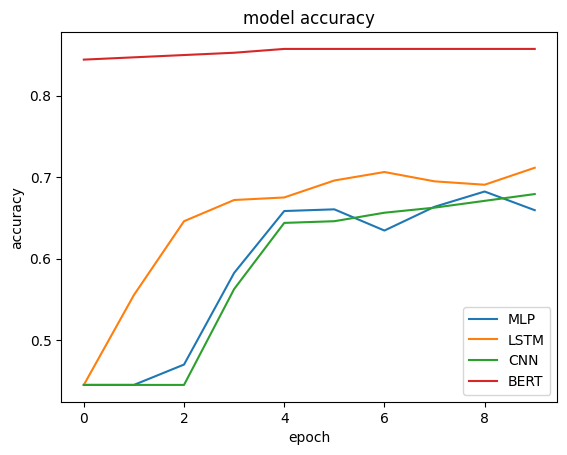

In [ ]:
plt.plot(mlp_history.history['val_accuracy'], label="MLP")
plt.plot(lstm_history.history['val_accuracy'], label="LSTM")
plt.plot(cnn_history.history['val_accuracy'], label="CNN")
plt.plot(bert_acc, label="BERT")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()

### Supplementary Material: Ensemble with Functional API (LSTM+CNN) (179k params // approx. 93s // 0.717)

In [ ]:
inputs = Input(shape=(1,), dtype=tf.string)
enc = encoder(inputs)
x = Embedding(input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        input_length=SEQ_LEN,
        mask_zero=True)(enc)

# Separate
## LSTM
lstm = Bidirectional(LSTM(64))(x)
lstm = Dense(64, activation='relu')(lstm)

## CNN
cnn = Conv1D(filters=64, kernel_size=8, activation='relu')(x)
cnn = GlobalMaxPooling1D()(cnn)

# Concatenate
y = concatenate([lstm,cnn])
y = Dense(64, activation='relu')(y)
y = Dropout(0.3)(y)
outputs = Dense(1)(y)

ens_model = Model(inputs=inputs, outputs=outputs)

In [ ]:
ens_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  (None, 60)          0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding_3 (Embedding)        (None, 60, 64)       64000       ['text_vectorization[3][0]']     
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 128)         66048       ['embedding_3[0][0]']        

In [ ]:
ens_model.compile(loss=BinaryCrossentropy(from_logits=True),
              optimizer=Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
ens_history = ens_model.fit(tf_train, epochs=10,
                    validation_data=tf_val,
                    validation_steps=30)

Epoch 1/10
267/267 [==============================] - 29s 71ms/step - loss: 0.6930 - accuracy: 0.5000 - val_loss: 0.6922 - val_accuracy: 0.4448
Epoch 2/10
267/267 [==============================] - 8s 29ms/step - loss: 0.6870 - accuracy: 0.5000 - val_loss: 0.6723 - val_accuracy: 0.4448
Epoch 3/10
267/267 [==============================] - 6s 21ms/step - loss: 0.6194 - accuracy: 0.6088 - val_loss: 0.5995 - val_accuracy: 0.6438
Epoch 4/10
267/267 [==============================] - 5s 19ms/step - loss: 0.5336 - accuracy: 0.7246 - val_loss: 0.5889 - val_accuracy: 0.6396
Epoch 5/10
267/267 [==============================] - 6s 23ms/step - loss: 0.4962 - accuracy: 0.7512 - val_loss: 0.5801 - val_accuracy: 0.6396
Epoch 6/10
267/267 [==============================] - 7s 26ms/step - loss: 0.4759 - accuracy: 0.7666 - val_loss: 0.5685 - val_accuracy: 0.7010
Epoch 7/10
267/267 [==============================] - 9s 33ms/step - loss: 0.4600 - accuracy: 0.7775 - val_loss: 0.5737 - val_accuracy: 0.653

In [ ]:
ens_loss, ens_acc = ens_model.evaluate(tf_test)

print('Test Loss:', ens_loss)
print('Test Accuracy:', ens_acc)

34/34 [==============================] - 0s 8ms/step - loss: 0.5796 - accuracy: 0.7167
Test Loss: 0.579640805721283
Test Accuracy: 0.7166979312896729


### Visualization with Supp. Material

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
bert_acc = [j['eval_accuracy'] for j in trainer.state.log_history[:10][1::2]]

In [ ]:
bert_acc += [bert_acc[-1]] * (10 - len(bert_acc))

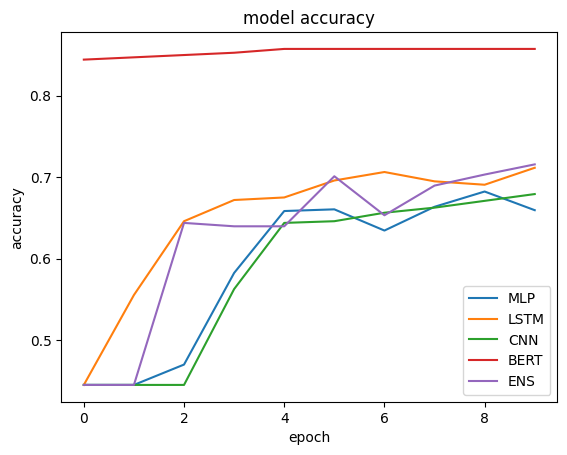

In [ ]:
plt.plot(mlp_history.history['val_accuracy'], label="MLP")
plt.plot(lstm_history.history['val_accuracy'], label="LSTM")
plt.plot(cnn_history.history['val_accuracy'], label="CNN")
plt.plot(bert_acc, label="BERT")
plt.plot(ens_history.history['val_accuracy'], label="ENS")
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.show()